In [1]:
import glob
import os
import cv2
import glob
import importlib
import h5py
import json
import copy
import _pickle as pkl
import numpy as np
import pandas as pd
import seaborn as sns
import pylab as pl

In [8]:
import scipy.stats as spstats
import analyze2p.utils as hutils
import analyze2p.plotting as pplot

import analyze2p.receptive_fields.utils as rfutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.scatter as sct
import analyze2p.retinotopy.segment as seg


In [3]:
rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
# Plotting
pplot.set_plot_params()
visual_areas, area_colors = pplot.set_threecolor_palette()

In [258]:
# output dir
dst_dir = os.path.join(aggregate_dir, 'receptive-fields', 'scatter')
print(dst_dir)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/scatter


In [259]:
# Receptive Field settings
traceid='traces001'
response_type='dff'
do_spherical_correction=False
is_neuropil = False
# ---------------------------------------------------
fit_desc = rfutils.get_fit_desc(response_type=response_type,
                               do_spherical_correction=do_spherical_correction)
data_id = '%s|%s' % (traceid, fit_desc)
data_id

'traces001|fit-2dgaus_dff-no-cutoff'

In [260]:
# Meta data
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets


#### Check 1 FOV

In [7]:
basedir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/scatter'

In [261]:
examples_dir = os.path.join(dst_dir, 'examples')
if not os.path.exists(examples_dir):
    os.makedirs(examples_dir)
    print(examples_dir)

In [283]:
# dk = '20191111_JC120_fov1'
# va='Li'
# experiment = 'rfs10'
dk = '20190522_JC084_fov1'
va='V1'
exp = 'rfs'

# va='Lm' 
# dk='20191111_JC120_fov1'
# experiment = 'rfs10'

fit_desc = rfutils.get_fit_desc(response_type='dff', do_spherical_correction=False)
# fit_results, fit_params = rfutils.load_fit_results(dk, experiment=experiment,
#                                            fit_desc=fit_desc)
# fitdf_ = rfutils.rfits_to_df(fit_results, fit_params)
# rfdf_ = fitdf_[fitdf_['r2']>0.5].copy()
# rfdf_['cell'] = rfdf_.index.tolist()

In [341]:
importlib.reload(sct)

<module 'analyze2p.scatter' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/scatter.py'>

In [336]:
# Get reliable c
eval_results, eval_params = rfutils.load_eval_results(dk, experiment=exp, 
                                    traceid=traceid, fit_desc=fit_desc)   
# List of reliable fits
reliable_ = rfutils.get_reliable_fits(eval_results['pass_cis'],
                                    pass_criterion='position')

In [404]:
# Soma position info 
regr_ = sct.load_models(dk, va)
rfpos_ = sct.get_aligned_soma(dk, va, regr_, experiment=exp,
                              traceid=traceid, response_type=response_type,
                              do_spherical_correction=do_spherical_correction, 
                              plot=False)

In [405]:
scatter0 = sct.load_scatter_results(dk, va, exp, verbose=False)
# Assign reliable index
found_rois = scatter0['cell'].unique()
scatter0['reliable'] = False
scatter0.loc[scatter0['cell'].isin(reliable_), 'reliable'] = True
# Get deviant or not
devs_ = sct.get_deviants_in_fov(dk, va, experiment=exp, redo_fov=False,
                     traceid=traceid, response_type=response_type, 
                     do_spherical_correction=do_spherical_correction)               
devs_ = devs_.rename(columns={'deviants': 'cell'})
devs_['deviant'] = True
# merge
scatter_ = scatter0.merge(devs_, on=['cell', 'axis'], how='outer')
scatter_ = scatter_.fillna(value=False).sort_values(by=['cell', 'axis'])\
                   .reset_index(drop=True)

In [406]:
# Only get reliable
rois_ = np.intersect1d(reliable_, rfpos_[rfpos_.inbounds]['cell'].unique())
boot_ = eval_results['bootdf'][eval_results['bootdf']['cell'].isin(rois_)]
cis_ = eval_results['cis'].loc[rois_]
fitrfs_ = rfpos_[rfpos_['cell'].isin(rois_)].copy()
fitrfs_.index = fitrfs_['cell'].values

In [407]:
fitrfs_

,x0,y0,sigma_x,sigma_y,theta,offset,amplitude,r2,cell,visual_area,...,predicted_ap_proj,predicted_x0,predicted_y0,predicted_ml_pos,predicted_ap_pos,deg_scatter_x0,deg_scatter_y0,dist_scatter_ml,dist_scatter_ap,inbounds
9,23.867409,-11.367222,24.879592,20.229131,0.103731,-0.007522,0.105426,0.852636,9,V1,...,1045.798988,22.057889,-11.003917,902.685634,676.001897,1.809520,-0.363305,104.685527,32.656175,True
10,24.144343,-11.700484,17.091076,23.108700,1.607293,-0.001759,0.033900,0.526608,10,V1,...,1015.843263,21.694094,-11.058787,918.015822,631.701027,2.450249,-0.641697,141.753445,57.679773,True
11,21.731005,-11.021150,25.488714,18.265764,0.323064,-0.010729,0.127964,0.840521,11,V1,...,1076.906123,21.931265,-11.223244,780.797648,786.167156,-0.200261,0.202094,11.585616,18.165493,True
12,20.274157,-12.508090,24.111595,17.282398,5.761685,-0.006539,0.113831,0.668465,12,V1,...,943.250502,21.544540,-11.639983,694.874035,681.946151,-1.270383,-0.868107,73.495024,78.030982,True
14,19.750648,-13.680022,20.936708,16.714212,2.342782,-0.002351,0.050092,0.538714,14,V1,...,837.909797,21.729617,-12.308864,662.959403,578.124562,-1.978970,-1.371158,114.488656,123.248374,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,9.983952,-14.554651,29.355372,23.628165,0.629951,-0.006411,0.060217,0.699447,246,V1,...,759.292560,12.150559,-14.174141,101.739929,826.025459,-2.166607,-0.380510,125.343950,34.202660,True
249,11.539420,-10.433394,21.133042,14.711042,0.021120,-0.005110,0.083963,0.609029,249,V1,...,1129.737406,15.217694,-11.070511,197.606814,1201.036915,-3.678274,0.637117,212.797938,57.268150,True
252,15.654976,-13.197787,19.910563,14.220851,0.296442,-0.006404,0.132595,0.799179,252,V1,...,881.256155,16.508747,-14.425841,428.994395,770.457828,-0.853771,1.228054,49.392941,110.385274,True
254,17.190074,-14.179973,24.517514,22.685233,0.988748,0.004882,-0.047279,0.613909,254,V1,...,792.971025,17.522486,-13.866475,515.381444,614.945486,-0.332412,-0.313498,19.230908,28.179178,True


<IPython.core.display.Javascript object>


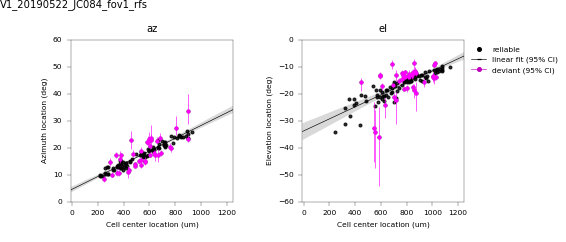

123
y=0.02x + 4.57
123
y=0.02x + -33.84


In [398]:
%matplotlib notebook
marker='o'
marker_size=5
ci = 0.95
lw=0.5
fill_marker=True
deviant_color='magenta'
scatter_kws={'s': marker_size, 'marker': marker}
line_kws={'lw': lw}

fig, axn = pl.subplots(1, 2, figsize=(7,3), sharex=True)
for ax, cond in zip(axn.flat, ['az', 'el']):
    # Get var names for V1/V2
    if cond=='az':
        ax.set_ylim([0, 60])
    else:
        #pass
        ax.set_ylim([-60, -0])
    xname = 'ml_proj' if cond=='az' else 'ap_proj'
    yname = 'x0' if cond=='az' else 'y0'
    ax.set_xlim([-10, 1250])
    # Get projected cortical position
    ax, devs_ = sct.fit_with_deviants(boot_, cis_, fitrfs_, 
                          xname=xname, yname=yname, ax=ax,
                          scatter_kws=scatter_kws, line_kws=line_kws, 
                          deviant_color=deviant_color,lw=lw)
    ax.set_title(cond)
    ylabel='Azimuth' if cond=='az' else 'Elevation'
    ax.set_ylabel('%s location (deg)' % ylabel)
    ax.set_xlabel('Cell center location (um)')
    devdf = pd.DataFrame({'deviants': devs_})
    devdf['cond'] = cond
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.75, bottom=0.25, top=0.85, wspace=0.3)

leg_h = pplot.custom_legend_markers(colors=['k', 'k', 'm'],
                    labels=['reliable', 'linear fit (95% CI)', 'deviant (95% CI)'],
                    markers=['o', '_', 'o'], lws=[0, 0.5, 0.5])
ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left',
          frameon=False, fontsize=6, markerscale=0.5)

pplot.label_figure(fig, '%s_%s_%s' % (va, dk, experiment))
figname = 'deviants_%s_%s_%s' % (dk, va, experiment)
pl.savefig(os.path.join(examples_dir, '%s.svg' % figname))

In [238]:
abs(axdf['deg_scatter_%s' % rf_label]).max()/2

4.76898739156251

In [239]:
rf_label='x0'
ctx_label = 'ml'
med_val = abs(axdf['deg_scatter_%s' % rf_label]).max()/4
ii = abs(abs(axdf['deg_scatter_%s' % rf_label])-med_val).argmin()

xi = axdf['%s_proj' % ctx_label].iloc[ii]
yi = axdf[rf_label].iloc[ii]

pred_deg = axdf['predicted_%s' % rf_label].iloc[ii]
offset_deg = axdf['deg_scatter_%s' % rf_label].iloc[ii]*-1 if yi>pred_deg\
                else axdf['deg_scatter_%s' % rf_label].iloc[ii]

xi, yi, offset_deg
print(axdf.iloc[ii])

x0                             10.431029
y0                            -34.127883
sigma_x                        33.228734
sigma_y                        41.070728
theta                           0.184815
offset                         -0.002858
amplitude                        0.04181
r2                               0.59239
cell                                  85
visual_area                           V1
datakey              20190522_JC084_fov1
experiment                           rfs
animalid                           JC084
fov                        FOV1_zoom2p0x
session                         20190522
fov_xpos                     1046.243444
fov_xpos_pix                       454.0
fov_ypos                      715.798043
fov_ypos_pix                       376.0
ml_pos                        257.001957
ap_pos                        131.356556
ml_proj                       254.915377
ap_proj                       245.475682
predicted_ml_proj             114.668557
predicted_ap_pro

In [409]:
fitrfs_

,x0,y0,sigma_x,sigma_y,theta,offset,amplitude,r2,cell,visual_area,...,predicted_ap_proj,predicted_x0,predicted_y0,predicted_ml_pos,predicted_ap_pos,deg_scatter_x0,deg_scatter_y0,dist_scatter_ml,dist_scatter_ap,inbounds
9,23.867409,-11.367222,24.879592,20.229131,0.103731,-0.007522,0.105426,0.852636,9,V1,...,1045.798988,22.057889,-11.003917,902.685634,676.001897,1.809520,-0.363305,104.685527,32.656175,True
10,24.144343,-11.700484,17.091076,23.108700,1.607293,-0.001759,0.033900,0.526608,10,V1,...,1015.843263,21.694094,-11.058787,918.015822,631.701027,2.450249,-0.641697,141.753445,57.679773,True
11,21.731005,-11.021150,25.488714,18.265764,0.323064,-0.010729,0.127964,0.840521,11,V1,...,1076.906123,21.931265,-11.223244,780.797648,786.167156,-0.200261,0.202094,11.585616,18.165493,True
12,20.274157,-12.508090,24.111595,17.282398,5.761685,-0.006539,0.113831,0.668465,12,V1,...,943.250502,21.544540,-11.639983,694.874035,681.946151,-1.270383,-0.868107,73.495024,78.030982,True
14,19.750648,-13.680022,20.936708,16.714212,2.342782,-0.002351,0.050092,0.538714,14,V1,...,837.909797,21.729617,-12.308864,662.959403,578.124562,-1.978970,-1.371158,114.488656,123.248374,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,9.983952,-14.554651,29.355372,23.628165,0.629951,-0.006411,0.060217,0.699447,246,V1,...,759.292560,12.150559,-14.174141,101.739929,826.025459,-2.166607,-0.380510,125.343950,34.202660,True
249,11.539420,-10.433394,21.133042,14.711042,0.021120,-0.005110,0.083963,0.609029,249,V1,...,1129.737406,15.217694,-11.070511,197.606814,1201.036915,-3.678274,0.637117,212.797938,57.268150,True
252,15.654976,-13.197787,19.910563,14.220851,0.296442,-0.006404,0.132595,0.799179,252,V1,...,881.256155,16.508747,-14.425841,428.994395,770.457828,-0.853771,1.228054,49.392941,110.385274,True
254,17.190074,-14.179973,24.517514,22.685233,0.988748,0.004882,-0.047279,0.613909,254,V1,...,792.971025,17.522486,-13.866475,515.381444,614.945486,-0.332412,-0.313498,19.230908,28.179178,True


In [410]:
importlib.reload(sct)

<module 'analyze2p.scatter' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/scatter.py'>

<IPython.core.display.Javascript object>


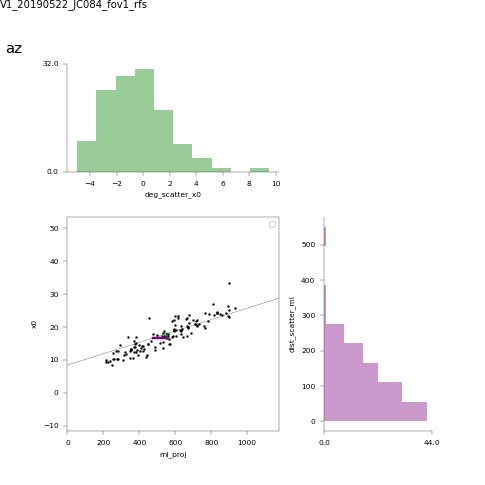

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


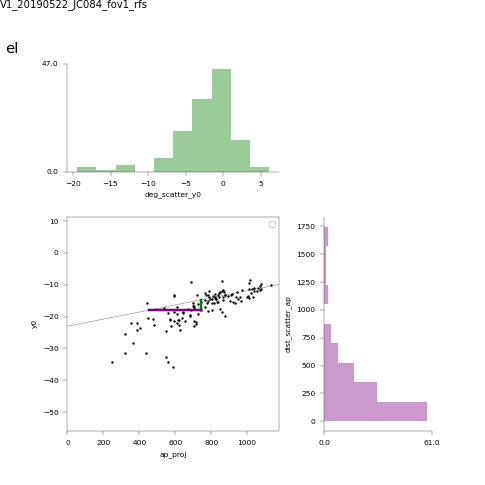

No handles with labels found to put in legend.


In [413]:
sz = 3
lw=0.5
nbins=10
color1='purple'
color2='green'

for cond in ['az', 'el']:
    dist_lim = ml_lim if cond=='az' else ap_lim
    fig = sct.plot_scatter_and_marginals(fitrfs_, regr_, roi_to_label= None,
                                         cond=cond,
                                        xlim=ap_lim, ylim=None, lw=2)
    pplot.label_figure(fig, '%s_%s_%s' % (va, dk, experiment))
    fig.text(0.01, 0.9, '%s' % cond, fontsize=12)
    pl.subplots_adjust(bottom=0.2, right=0.8)
    figname = 'scatter_marginals_%s__%s_%s_%s' % (cond, dk, va, experiment)
    #pl.savefig(os.path.join(examples_dir, '%s.svg' % figname))

# Aggregate deviants

In [414]:
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type,
                                  do_spherical_correction=do_spherical_correction)
deviants, no_results = sct.aggregate_deviant_cells(rf_fit_desc, meta=None, traceid=traceid,
                             create_new=False, redo_fov=False)

In [277]:
# df_ = sct.load_scatter_results(dk, va, exp, verbose=False)
# df_

# Load all results from scatter analysis

In [415]:
meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()

In [416]:
missing=[]
d_list=[]
no_eval=[]
for (va, dk, exp), g in meta.groupby(['visual_area', 'datakey', 'experiment']):
    # Load scatter calculations
    df_ = sct.load_results(dk, va, exp, verbose=False)
    if df_ is None:
        missing.append((va, dk, exp))
        continue
    # get reliable or not
    eval_results, eval_params = rfutils.load_eval_results(dk,
                                    experiment=exp, 
                                    traceid=traceid, 
                                    fit_desc=fit_desc)   
    if eval_results is None:
        no_eval.append((dk, va, exp))
        continue
    reliable_ = rfutils.get_reliable_fits(eval_results['pass_cis'],
                                        pass_criterion='position')
    # Assign reliable index
    found_rois = df_['cell'].unique()
    df_['reliable'] = False
    df_.loc[df_['cell'].isin(reliable_), 'reliable'] = True
    # Get deviant or not
    curr_deviants = deviants[(deviants.visual_area==va) 
                          & (deviants.datakey==dk)].copy()
    df_['deviant'] = False
    for dev_cond, dev_vals in curr_deviants.groupby(['cond']):
        dev_rois = dev_vals['deviants'].values
        df_.loc[(df_.axis==dev_cond) \
                & (df_['cell'].isin(dev_rois)), 'deviant'] = True
    df_['visual_area'] = va
    df_['datakey'] = dk
    df_['experiment'] = exp
    d_list.append(df_)
scatterdf = pd.concat(d_list, axis=0)
scatterdf.shape

(4568, 10)

In [417]:
count_cols=['visual_area', 'datakey', 'experiment', 'cell']
fit_ = aggr.count_n_cells(scatterdf, name='fit', count_cols=count_cols, reset_index=False)
reliable_ = aggr.count_n_cells(scatterdf[scatterdf['reliable']], name='reliable', 
                               count_cols=count_cols, reset_index=False)
deviants_ = aggr.count_n_cells(scatterdf[scatterdf['deviant']], name='deviant', 
                              count_cols=count_cols, reset_index=False) 
# Get counts
counts0 = fit_.merge(reliable_, left_index=True, right_index=True, how='outer')
countdf = counts0.merge(deviants_, left_index=True, right_index=True, how='outer')
countdf = countdf.fillna(value=0).reset_index()
countdf['fraction_reliable'] = countdf['reliable']/countdf['fit'].astype(float)
countdf['fraction_deviant'] = countdf['deviant']/countdf['fit'].astype(float)

<IPython.core.display.Javascript object>


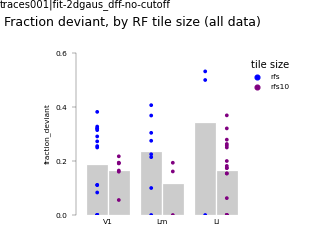

'fraction_deviant_alldata'

In [418]:
%matplotlib notebook
fig, ax = pl.subplots(figsize=(4,3))
fig.set_facecolor('1')
#exp_colors = {'rfs': [0.7]*3, 'rfs10': [0.4]*3}
# exp_colors = {'rfs': 'blue', 'rfs10': 'purple'}
sns.stripplot(x='visual_area', y='fraction_deviant', data=countdf, ax=ax,
              hue='experiment', palette=exp_colors, dodge=True, 
              order=visual_areas, jitter=False,size=3)
sns.barplot(x='visual_area', y='fraction_deviant', data=countdf, ax=ax,
              hue='experiment', palette={'rfs': [0.8]*3, 'rfs10': [0.8]*3}, 
             edgecolor='w',ci=None, order=visual_areas)
pplot.crop_legend_labels(ax, 2,start_ix=0, bbox_to_anchor=(1, 1), loc='upper left',
        fontsize=6, title='tile size', markerscale=0.5)
ax.set_box_aspect(1)
ax.set_yticks(np.linspace(0, 0.6, 4))
ax.set_ylim([0, 0.6])
ax.set_xlabel('')
ax.tick_params(which='both', axis='x', size=0)
sns.despine(bottom=True, offset=4, trim=True)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, top=0.8)

pplot.label_figure(fig, data_id)
fig.text(0.01, 0.9, "Fraction deviant, by RF tile size (all data)")

figname = 'fraction_deviant_alldata' 
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
figname

## Load REGR for retino gradients

In [420]:
import analyze2p.stats as pstats

In [421]:
bw_colors=dict((v, [0.7]*3) for v in visual_areas)
axis_colors={'az': [0.7]*3,
             'el': [0.5]*3}
exp_colors={'rfs':'blue', 'rfs10': 'purple'}

In [546]:
r_=[]
for (va, dk), g in meta.groupby(['visual_area', 'datakey']):
    regr_ = sct.load_models(dk, va)
    regr_['visual_area'] = va
    regr_['datakey'] = dk
    r_.append(regr_)
REGR = pd.concat(r_, axis=0)

In [547]:
# Only get ones that pass 
r2_thr=0.5
pass_regr = pd.concat([r for (va, dk), r in REGR.groupby(['visual_area', 'datakey'])\
                       if (round(r[r.cond=='az']['R2'].values[0], 1)>=r2_thr) 
                       and (round(r[r.cond=='el']['R2'].values[0], 1)>=r2_thr)])
#### Only include dataset if gradient was well-fit
passdf = pd.concat([g for (va, dk), g in scatterdf[scatterdf['reliable']]\
                    .groupby(['visual_area', 'datakey'])\
           if not pass_regr.query('@va==visual_area and @dk==datakey').empty])\
            .reset_index(drop=True)
# Only get ones that pass 
REGR.shape, pass_regr.shape

((108, 9), (62, 9))

In [607]:
pass_r = REGR[REGR.visual_area=='Li']['datakey']
np.unique([k for k in pass_r if k \
     not in regr_df[regr_df.visual_area=='Li']['datakey'].unique()])


array(['20190522_JC089_fov1', '20190528_JC092_fov1',
       '20190602_JC091_fov1', '20190606_JC091_fov1',
       '20190607_JC091_fov1', '20190612_JC099_fov1',
       '20190614_JC091_fov1', '20191012_JC113_fov1',
       '20191012_JC113_fov2', '20191018_JC113_fov1',
       '20191105_JC117_fov1', '20191111_JC120_fov1'], dtype='<U19')

#### 1 expeeriment per fov only

In [548]:
passdf['n_cells'] = None
f_=[]
for (va, dk), g in passdf.groupby(['visual_area', 'datakey']):
#     if va=='Lm' and dk in['20190430_JC078_fov1', '20190508_JC083_fov1']:
#         continue
    if va in ['V1', 'Lm']:
        if 'rfs' in g['experiment'].values:
            df_ = g[g.experiment=='rfs'].copy()
        elif 'rfs10' in g['experiment'].values:
            df_ = g[g.experiment=='rfs10'].copy()
    elif va=='Li':
        if 'rfs10' in g['experiment'].values:
            df_ = g[g.experiment=='rfs10'].copy()
        elif 'rfs' in g['experiment'].values:
            df_ = g[g.experiment=='rfs'].copy()
    df_['n_cells'] = len(g['cell'].unique())
    # passdf.loc[g.index, 'n_cells'] = len(g['cell'].unique())
    f_.append(df_)
finaldf0 = pd.concat(f_, axis=0)

In [553]:
min_ncells = 5
passdf['n_cells'] = None
for (va, dk,exp), g in passdf.groupby(['visual_area', 'datakey', 'experiment']):
    passdf.loc[g.index, 'n_cells'] = len(g['cell'].unique())
DF = finaldf0[finaldf0['n_cells']>min_ncells]

In [584]:
# drop duplicates
counts = aggr.count_n_cells(finaldf0)
u_dkeys = aggr.drop_repeats(counts, colname='n_cells')

finaldf = pd.concat([g for (va, dk), g in finaldf0.groupby(['visual_area', 'datakey'])\
                    if (va, dk) in u_dkeys])
print(finaldf0.shape,DF.shape, finaldf.shape)

(2116, 11) (2104, 11) (1652, 11)


In [585]:
k1 = finaldf['datakey'].unique()
k0 = finaldf0['datakey'].unique()
len(k1), len(k0)

(19, 27)

In [586]:
va='Lm'
np.unique([k for k in finaldf0[finaldf0.visual_area==va]['datakey'] \
 if k not in finaldf[finaldf.visual_area==va]['datakey'].values])

array(['20190506_JC080_fov1', '20190513_JC078_fov1'], dtype='<U19')

In [587]:
importlib.reload(pplot)
%matplotlib notebook

| visual_area   |   datakey |
|:--------------|----------:|
| Li            |         5 |
| Lm            |         4 |
| V1            |        10 |


<IPython.core.display.Javascript object>


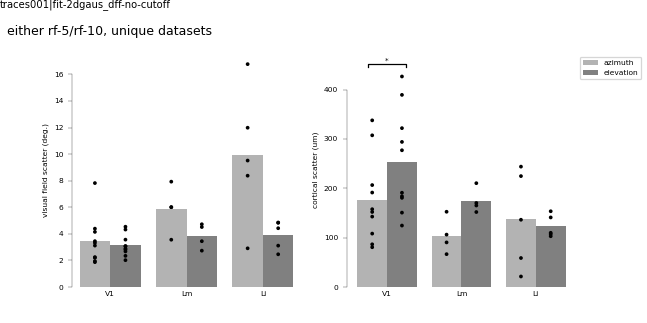

   t_stat     p_val visual_area        metric
0     7.0  0.037109          V1  dist_scatter


,t_stat,p_val,visual_area,metric
0,27.0,1.000000,V1,deg_scatter
1,0.0,0.125000,Lm,deg_scatter
2,0.0,0.062500,Li,deg_scatter
0,7.0,0.037109,V1,dist_scatter
1,0.0,0.125000,Lm,dist_scatter
2,5.0,0.625000,Li,dist_scatter


In [588]:
plotd = finaldf.groupby(['visual_area', 'datakey', 'axis']).mean().reset_index()
print(plotd[['visual_area', 'datakey']]\
      .drop_duplicates().groupby(['visual_area']).count()['datakey'].to_markdown())
s_=[]
fig, axn = pl.subplots(1,2, figsize=(8, 4))
fig.patch.set_facecolor('w')
for ai, metric in enumerate(['deg_scatter', 'dist_scatter']):
    ax=axn[ai]
    sns.barplot(x='visual_area', y=metric, data=plotd, ax=ax,
              order=visual_areas, hue='axis', palette=axis_colors, ci=None)
    sns.stripplot(x='visual_area', y=metric, data=plotd, ax=ax,
              order=visual_areas, hue='axis', dodge=True,
              jitter=False, size=3,
              palette=dict((k, 'k') for k in ['az', 'el']))
    ylabel = 'cortical scatter (um)' if metric=='dist_scatter' \
                else 'visual field scatter (deg.)'
    ax.set_ylabel(ylabel)
    if metric=='dist_scatter':
        offset=20; h=5;
    else:
        offset=1; h=.1;
    # stats
    stats_ = pstats.paired_ttests(plotd, metric=metric, c1='az', c2='el',
                                        compare_var='axis', ttest=False)
    stats_['metric'] = metric
    s_.append(stats_)
    pplot.annotate_sig_on_paired_plot(ax, plotd, stats_, metric, offset=offset, h=h)
    ax.legend_.remove()
statdf = pd.concat(s_)
# custom legend
leg_h = pplot.custom_legend_markers(colors=[axis_colors['az'], axis_colors['el']],
                                   labels=['azimuth', 'elevation'],
                                    use_patch=True)
ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left')

pl.subplots_adjust(left=0.1, right=0.8, wspace=0.2, bottom=0.2, top=0.85)
sns.despine(bottom=True, trim=True)
for ax in axn:
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')

pplot.label_figure(fig, data_id)
fig.text(0.01, 0.9, 'either rf-5/rf-10, unique datasets')
    
figname = 'scatter_perFOV_reliable'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
statdf

<IPython.core.display.Javascript object>


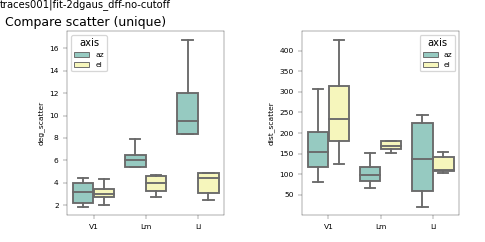

In [589]:
fig, axn = pl.subplots(1, 2, figsize=(6,3))
ax=axn[0]
sns.boxplot(x='visual_area', y='deg_scatter', hue='axis', data=plotd, 
            order=visual_areas, palette='Set3', fliersize=0, ax=ax)
ax=axn[1]
sns.boxplot(x='visual_area', y='dist_scatter', hue='axis', data=plotd, 
            order=visual_areas, palette='Set3', fliersize=0, ax=ax)
for ax in axn:
    ax.set_xlabel('')
pl.subplots_adjust(bottom=0.2, right=0.85, wspace=0.5)
fig.text(0.01, 0.9, 'Compare scatter (unique)')
pplot.label_figure(fig, data_id)


In [591]:
exp_colors

{'rfs': 'blue', 'rfs10': 'purple'}

In [592]:
passdf['n_cells'] = None
for (va, dk,exp), g in passdf.groupby(['visual_area', 'datakey', 'experiment']):
    passdf.loc[g.index, 'n_cells'] = len(g['cell'].unique())
DF_all = passdf[passdf['n_cells']>=min_ncells]

<IPython.core.display.Javascript object>


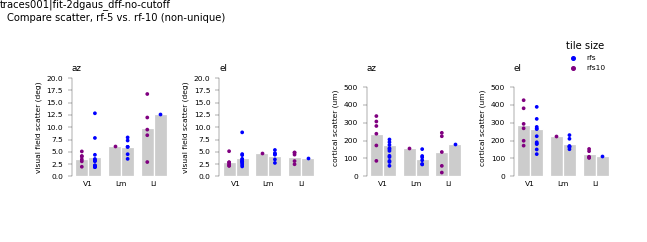

In [593]:
exp_colors = {'rfs': 'blue', 'rfs10': 'purple'}

plotd_exp = DF_all.groupby(['visual_area', 'datakey', 'axis', 'experiment'])\
                .mean().reset_index()
# print(plotd[['visual_area', 'datakey']]\
#       .drop_duplicates().groupby(['visual_area']).count()['datakey'].to_markdown())
s_=[]
fig, axn = pl.subplots(1,4, figsize=(8, 3))
fig.patch.set_facecolor('w')
ai=0
for mi, metric in enumerate(['deg_scatter', 'dist_scatter']):
    for ei, (exp, exp_df) in enumerate(plotd_exp.groupby('axis')):
        ax=axn[ai]
        ylabel = 'cortical scatter (um)' if metric=='dist_scatter' \
                    else 'visual field scatter (deg)'
        ax.set_title(exp, loc='left', fontsize=7)
        sns.barplot(x='visual_area', y=metric, data=exp_df, ax=ax,
                  order=visual_areas, hue='experiment', 
                    palette={'rfs': [0.8]*3, 'rfs10': [0.8]*3}, 
                    edgecolor='w', ci=None)
        sns.stripplot(x='visual_area', y=metric, data=exp_df, ax=ax,
                  order=visual_areas, hue='experiment', dodge=True,
                  jitter=False, size=3,
                  palette=exp_colors)
        ax.legend_.remove()
        ax.set_box_aspect(1)
        ax.set_ylabel(ylabel)
        if metric=='dist_scatter':
            offset=20; h=5;
            ax.set_ylim([0, 550])
        else:
            ax.set_ylim([0, 20])
            offset=1; h=.1;
        ai+=1
        try:
            statdf = pstats.paired_ttests(exp_df, metric=metric, c1='az', c2='el',
                                                compare_var='experiment', ttest=False)
            statdf['metric'] = metric
            s_.append(statdf)
            pplot.annotate_sig_on_paired_plot(ax, exp_df, statdf, 
                                              metric, offset=offset, h=h)
        except Exception as e:
            continue

pl.subplots_adjust(left=0.1, right=0.8, wspace=0.2, bottom=0.2, top=0.85)
sns.despine(bottom=True, trim=True)
for ax in axn.flat:
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')
    #ax.legend_.remove()
# custom legend
leg_h = pplot.custom_legend_markers(colors=[exp_colors['rfs'], exp_colors['rfs10']],
                                   labels=['rfs', 'rfs10'],
                                   markers='o', lws=0)
axn[-1].legend(handles=leg_h, bbox_to_anchor=(1,1), frameon=False,
                    loc='lower right', fontsize=6, markerscale=0.5, title='tile size')

fig.text(0.01, 0.92, 'Compare scatter, rf-5 vs. rf-10 (non-unique)', fontsize=8)
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, wspace=0.5)

pplot.label_figure(fig, data_id)

figname = 'scatter_compare_rf5-rf10_reliable'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>


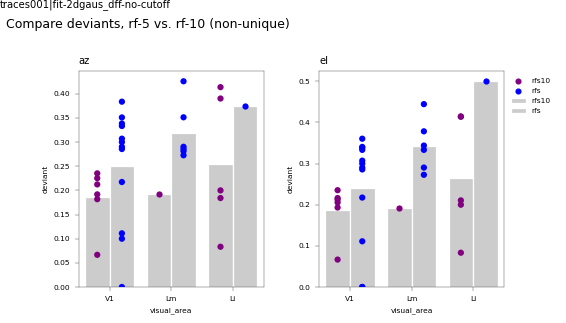

In [594]:

fig, axn = pl.subplots(1, 2, figsize=(7,4))
fig.set_facecolor('w')
for ai, (exp, exp_df) in enumerate(plotd_exp.groupby('axis')):
    ax=axn[ai]
    sns.barplot(x='visual_area', y='deviant', data=exp_df,
               hue='experiment', ax=ax, order=visual_areas, 
               palette={'rfs': [0.8]*3, 'rfs10': [0.8]*3}, edgecolor='w', ci=None)
    
    sns.stripplot(x='visual_area', y='deviant', data=exp_df,
               hue='experiment', ax=ax, order=visual_areas, dodge=True,
               palette=exp_colors, jitter=False)
    ax.set_title(exp, loc='left')
    
    ax.legend_.remove()
axn[1].legend(bbox_to_anchor=(1,1), loc='upper left', markerscale=0.5, frameon=False)

fig.text(0.01, 0.92, 'Compare deviants, rf-5 vs. rf-10 (non-unique)')
pplot.label_figure(fig, data_id)
pl.subplots_adjust(top=0.8, wspace=0.3, bottom=0.2, right=0.8)

figname = 'deviants_compare_rfs5-v-rfs10'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

In [595]:
importlib.reload(pplot)
%matplotlib inline

   t_stat  p_val visual_area        metric
0     7.0  0.037          V1  dist_scatter
|    |   t_stat |   p_val | visual_area   | metric       |
|---:|---------:|--------:|:--------------|:-------------|
|  0 |       27 |   1     | V1            | deg_scatter  |
|  1 |        0 |   0.125 | Lm            | deg_scatter  |
|  2 |        0 |   0.062 | Li            | deg_scatter  |
|  0 |        7 |   0.037 | V1            | dist_scatter |
|  1 |        0 |   0.125 | Lm            | dist_scatter |
|  2 |        5 |   0.625 | Li            | dist_scatter |


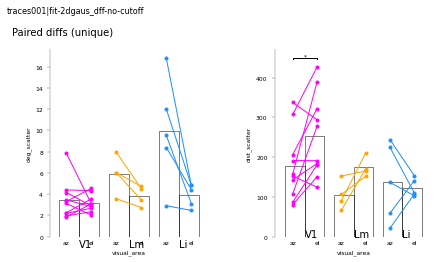

In [596]:
plotd = finaldf.groupby(['visual_area', 'datakey', 'axis']).mean().reset_index()

# Paired: spstats.wilcoxon()
offset=2
fig, axn = pl.subplots(1,2, figsize=(6.5, 4))
fig.patch.set_facecolor('w')

s_=[]
for ai, metric in enumerate(['deg_scatter', 'dist_scatter']):
    ax=axn[ai]
    ax, stats_ = pplot.pairwise_compare_single_metric(plotd, 
                 curr_metric=metric, ax=ax, size=3,
                 c1='az', c2='el', compare_var='axis', 
                 ttest=False, return_stats=True, bar_ci=None)
    stats_['metric'] = metric
    if metric=='dist_scatter':
        offset=20; h=2;
    else:
        offset=1; h=.1;
    pplot.annotate_sig_on_paired_plot(ax, plotd, stats_, metric, offset=offset, h=h)
    s_.append(stats_)
statsdf = pd.concat(s_)
print(statsdf.to_markdown())
pl.subplots_adjust(left=0.1, right=0.9, wspace=0.5, bottom=0.2, top=0.85)
fig.text(0.01, 0.9, 'Paired diffs (unique)')

pplot.label_figure(fig, data_id)
figname = 'scatter_perFOV_paired_reliable'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

In [597]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

#perform two-way ANOVA
model = ols('deg_scatter ~ C(visual_area) + C(axis) + C(visual_area):C(axis)', \
            data=plotd).fit()
sm.stats.anova_lm(model, typ=2)


,sum_sq,df,F,PR(>F)
C(visual_area),88.830194,2.0,9.229420,0.000685
C(axis),44.588297,1.0,9.265411,0.004642
C(visual_area):C(axis),53.361593,2.0,5.544247,0.008563
Residual,153.994839,32.0,NaN,NaN


#### Cortical magnification

In [598]:
import analyze2p.stats as pstats
import statsmodels.api as sm
import pingouin as pg

In [599]:
pass_regr

,R2,RMSE,pearson_p,pearson_r,coefficient,intercept,cond,visual_area,datakey
0,0.870037,4.410720,2.063719e-35,0.932758,0.136584,-49.987857,az,Li,20190527_JC092_fov3
1,0.912794,1.532876,5.249799e-42,0.955403,0.022986,-17.637641,el,Li,20190527_JC092_fov3
0,0.582064,10.744265,7.702743e-50,0.762931,0.053356,-3.087934,az,Li,20190609_JC099_fov1
1,0.464516,7.690906,3.555443e-36,0.681554,0.044004,-14.375481,el,Li,20190609_JC099_fov1
0,0.916933,6.433112,7.524883e-31,0.957566,0.142649,-85.969018,az,Li,20190617_JC099_fov1
...,...,...,...,...,...,...,...,...,...
1,0.702929,1.543208,4.044429e-96,0.838409,0.009155,-13.028829,el,V1,20190622_JC085_fov1
0,0.624337,3.594858,8.827261e-73,0.790150,0.021267,21.993912,az,V1,20191006_JC110_fov1
1,0.462352,3.749262,8.597404e-47,0.679965,0.013432,-15.866369,el,V1,20191006_JC110_fov1
0,0.856802,1.324508,9.063891e-76,0.925636,0.011227,31.252423,az,V1,20191111_JC117_fov1


In [600]:
regr_df = pd.concat([g for (va, dk), g in pass_regr.groupby(['visual_area', 'datakey'])\
                     if not plotd.query('@va==visual_area and @dk==datakey').empty])
print(regr_df[['visual_area', 'datakey']]\
      .drop_duplicates()['visual_area'].value_counts().to_markdown())
regr_df['cortical_mag'] = np.abs(1./regr_df['coefficient'])

|    |   visual_area |
|:---|--------------:|
| V1 |            10 |
| Li |             5 |
| Lm |             4 |


In [601]:
cmag_df = regr_df[['visual_area','datakey']].drop_duplicates().reset_index(drop=True)
cmag_df['cortical_mag'] = None
cmag_df['cortical_mag_ratio'] = None
for (va, dk), cg in cmag_df.groupby(['visual_area', 'datakey']):
    r_df = regr_df[(regr_df.visual_area==va) & (regr_df.datakey==dk)].copy()
    mean_mag = r_df['coefficient'].abs().mean()
    ratio_mag = float(r_df[r_df.cond=='el']['cortical_mag'])\
                /float(r_df[r_df.cond=='az']['cortical_mag'])
    cmag_df.loc[cg.index, 'cortical_mag'] = mean_mag
    cmag_df.loc[cg.index, 'cortical_mag_ratio'] = ratio_mag
cmag_df['cortical_mag'] = abs(cmag_df['cortical_mag'].astype(float))
cmag_df['cortical_mag_ratio'] = abs(cmag_df['cortical_mag_ratio'].astype(float))


In [602]:
regr_df.groupby('visual_area')['cortical_mag'].describe()

,count,mean,std,min,25%,50%,75%,max
visual_area,,,,,,,,
Li,10.0,22.467169,12.191559,7.010195,14.373192,20.733472,31.796744,43.504111
Lm,8.0,32.599360,17.638513,13.386065,17.781414,29.508201,45.375611,62.211299
V1,20.0,68.352918,29.867536,24.463716,46.354382,61.991039,83.312688,151.250603


In [603]:
regr_df.groupby(['visual_area', 'cond'])['cortical_mag'].describe()

count       mean        std        min        25%  \
visual_area cond                                                      
Li          az      5.0  12.386188   5.082227   7.010195   7.321478   
            el      5.0  32.548150   7.384597  22.725015  31.608826   
Lm          az      4.0  18.122042   5.312012  13.386065  14.630791   
            el      4.0  47.076678  11.781704  33.653318  41.810960   
V1          az     10.0  54.257064  20.319421  24.463716  43.300970   
            el     10.0  82.448773  32.075523  40.516312  61.826302   

                        50%        75%         max  
visual_area cond                                    
Li          az    14.317715  14.539624   18.741929  
            el    31.859384  33.043413   43.504111  
Lm          az    16.869509  20.360761   25.363084  
            el    46.221048  51.486767   62.211299  
V1          az    47.897835  66.987831   89.071477  
            el    75.747630  98.890315  151.250603

In [604]:
importlib.reload(pplot)

<module 'analyze2p.plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py'>

In [605]:
stats_

,t_stat,p_val,visual_area,metric
0,7.0,0.037,V1,dist_scatter
1,0.0,0.125,Lm,dist_scatter
2,5.0,0.625,Li,dist_scatter


   t_stat  p_val visual_area
0     1.0  0.004          V1
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/scatter


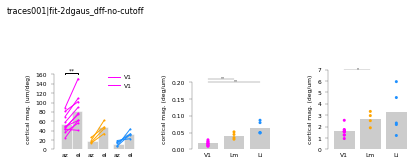

In [606]:
s_=[]
fig, axn = pl.subplots(1,3, figsize=(7,3))
fig.patch.set_facecolor('w')
ax=axn[0]
metric='cortical_mag'
ax, stats_ = pplot.pairwise_compare_single_metric(regr_df, 
                 curr_metric=metric, ax=ax, size=1,
                 c1='az', c2='el', compare_var='cond', 
                 ttest=False, return_stats=True, bar_ci=None,
                 facecolor=[0.8]*3, edgecolor='w', label_areas=False)
pl.subplots_adjust(bottom=.2)
pplot.annotate_sig_on_paired_plot(ax, regr_df, stats_, metric, offset=10, h=2)
pplot.crop_legend_labels(ax, 2, start_ix=2, markerscale=0.1, 
                        bbox_to_anchor=(1,1), loc='upper right', fontsize=6)
ax.set_box_aspect(1)
ax.tick_params(which='both', axis='x', size=0)
sns.despine(bottom=True, trim=True, ax=ax)
ylabel = 'cortical mag. (um/deg)' 
ax.set_ylabel(ylabel)

for ai, metric in enumerate(['cortical_mag', 'cortical_mag_ratio']):
    ax=axn[ai+1]
    ymax=0.2 if metric=='cortical_mag' else 7
    ylim = (0, ymax+0.04) if metric=='cortical_mag' else (0, ymax+0.04)
    pplot.stripplot_metric_by_area(cmag_df, metric, area_colors=area_colors,
                                markersize=3, ax=ax,
                                sig_fontsize=4, jitter=False, ylim=ylim,
                                plot_means=True, y_loc=ymax-0.01, offset=0.01,
                                mean_style='bar', mean_type='mean', aspect=2)
    stats = pg.pairwise_ttests(dv=metric, between='visual_area', data=cmag_df,
                           subject='datakey', tail='one-sided', # use one-talied bec pos
                           padjust='fdr_bh', parametric=False)
    stats['metric'] = metric
    s_.append(stats)
    ylabel = 'cortical mag. (deg/um)' if ai in [0, 1] \
                else 'ratio EL:AZ'
    ax.set_ylabel(ylabel)
statsdf = pd.concat(s_)

for ax in axn:
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, top=0.85, wspace=0.7)
pplot.label_figure(fig, data_id)

pl.savefig(os.path.join(dst_dir, 'cortical_magnification_reliable.svg'))
print(dst_dir)

In [578]:
stats_

,t_stat,p_val,visual_area
0,1.0,0.004,V1
1,0.0,0.125,Lm
2,0.0,0.062,Li


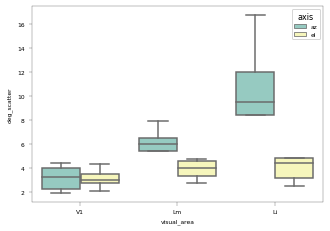

In [579]:
fig, ax= pl.subplots()
sns.boxplot(x='visual_area', y='deg_scatter', hue='axis', data=plotd, 
            order=visual_areas, palette='Set3', fliersize=0)
pl.subplots_adjust(bottom=0.2, right=0.8)

In [399]:
plotd['subject'] = None
for vi, ((va, dk), g) in enumerate(plotd.groupby(['visual_area','datakey'])):
#     dkeys = list(plotd[plotd.visual_area==va]['datakey'].unique())
#     ix = dkeys.index(dk)
#     print(dk, ix)
    plotd.loc[g.index, 'subject'] = vi

In [400]:
aov_deg = pg.mixed_anova(data=plotd, dv='deg_scatter', between='visual_area',
                     within='axis', subject='subject', effsize='ng2')
aov_deg

,Source,SS,DF1,DF2,MS,F,p-unc,ng2,eps
0,visual_area,97.764608,2,14,48.882304,7.839135,0.005198,0.432205,NaN
1,axis,38.955274,1,14,38.955274,13.257993,0.002671,0.232721,1.0
2,Interaction,57.517905,2,14,28.758953,9.787789,0.002191,0.309314,NaN


In [401]:
aov_dist = pg.mixed_anova(data=plotd, dv='dist_scatter', between='visual_area',
                     within='axis', subject='subject', effsize='ng2')
aov_dist

,Source,SS,DF1,DF2,MS,F,p-unc,ng2,eps
0,visual_area,74059.376068,2,14,37029.688034,3.791527,0.048318,0.280370,NaN
1,axis,31882.579334,1,14,31882.579334,8.365125,0.011822,0.143633,1.0
2,Interaction,21402.979878,2,14,10701.489939,2.807781,0.094339,0.101200,NaN


In [402]:
# Having calculated the ANOVA, we can now run pairwise T-tests. By default, 
# Pingouin will calculate the within between interaction (in this case, year sex).
metric='deg_scatter'
pg.pairwise_ttests(data=plotd, dv=metric, between='visual_area', 
                   within='axis', subject='subject')

,Contrast,axis,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,axis,-,az,el,True,True,2.513548,16.000000,two-sided,0.023037,2.719,0.701978
1,visual_area,-,Li,Lm,False,True,1.469514,5.424041,two-sided,0.197182,0.917,0.799073
2,visual_area,-,Li,V1,False,True,2.914630,4.285126,two-sided,0.039989,4.091,1.951590
3,visual_area,-,Lm,V1,False,True,2.846695,4.141271,two-sided,0.044702,3.53,1.915577
4,axis * visual_area,az,Li,Lm,False,True,1.748638,4.913228,two-sided,0.141803,1.13,0.939712
5,axis * visual_area,az,Li,V1,False,True,3.059098,4.209690,two-sided,0.035239,4.88,2.063734
6,axis * visual_area,az,Lm,V1,False,True,3.283925,4.373093,two-sided,0.026638,5.827,2.147329
7,axis * visual_area,el,Li,Lm,False,True,0.162378,6.960094,two-sided,0.875622,0.513,0.094669
8,axis * visual_area,el,Li,V1,False,True,1.685164,6.156810,two-sided,0.141674,1.075,0.990541
9,axis * visual_area,el,Lm,V1,False,True,1.568538,4.907088,two-sided,0.178641,0.981,0.970478


In [403]:
# To get the between * within interaction, one can use the within_first argument:
pg.pairwise_ttests(data=plotd, dv=metric, between='visual_area', 
                   within='axis', subject='subject', within_first=False)


,Contrast,visual_area,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,visual_area,-,Li,Lm,False,True,1.469514,5.424041,two-sided,0.197182,0.917,0.799073
1,visual_area,-,Li,V1,False,True,2.914630,4.285126,two-sided,0.039989,4.091,1.951590
2,visual_area,-,Lm,V1,False,True,2.846695,4.141271,two-sided,0.044702,3.53,1.915577
3,axis,-,az,el,True,True,2.513548,16.000000,two-sided,0.023037,2.719,0.701978
4,visual_area * axis,Li,az,el,True,True,3.160309,4.000000,two-sided,0.034174,2.911,1.471637
5,visual_area * axis,Lm,az,el,True,True,3.806179,3.000000,two-sided,0.031871,3.232,1.285266
6,visual_area * axis,V1,az,el,True,True,-0.348360,7.000000,two-sided,0.737812,0.354,-0.138601


In [405]:
# shapiro-test (should b p>0.05 if noramally distributed)


#  homogeneity of variance assumption of the between-subject factor (group) 
# can be checked using the Levene’s test
# (homogeneuity of variances if p>0.05)


In [406]:
k = plotd['visual_area'].nunique()  # Number of groups
n = plotd.shape[0] / k  # Number of observations per group
print(k, n)
achieved_power = pg.power_anova(eta=aov.loc[0, 'ng2'], k=k, n=n, alpha=0.05)
print('Achieved power: %.4f' % achieved_power)

3 11.333333333333334


NameError: name 'aov' is not defined

In [407]:
pg.pairwise_tukey(data=plotd, dv='deg_scatter', between='axis', within='visual_area')


TypeError: pairwise_tukey() got an unexpected keyword argument 'within'

In [409]:
posthocs = pg.pairwise_ttests(dv='deg_scatter', within=['visual_area', 'axis'],
                             subject='datakey', data=plotd)
posthocs

ValueError: Repeated measures dataframe is not balanced. `Subjects` must have the same number of elements in all conditions, even when missing values are present.

In [410]:
pg.sphericity(data=plotd, dv='deg_scatter', subject='datakey', 
              within=['visual_area', 'axis'])[-1]

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/core/frame.py:8525: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


LinAlgError: Eigenvalues did not converge